In [36]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
from nesterov import nesterov
from ms import ms_acc_prox_method
from um import taylor_acc_prox_method
from fgm import fgm

In [38]:
np.random.seed(7)

In [39]:
n = 500
p = 20000
m = 1

$\sum_{i = 1}^n \lambda_i = 1,\quad [e_i]_j \sim \mathcal{U}(1, 2)$ for all $j \in [1, n]$

$G^2 = \sum_{i = 1}^n \lambda_i e_i e_i^\top$

$L_i = G^2_{i i}$

In [40]:
lambda_ = np.random.random(n)
lambda_ /= lambda_.sum()

e = np.matrix(np.random.random(size=(n, n)) + 1)

G_wave = np.array(np.multiply(e, lambda_).dot(e.T))

Li = np.diag(G_wave)

In [41]:
def test_G_correctness(G):
    """
    Test for matrix G generation
    
    param: G             generated matrix
    :return: correctness matrix correctness boolean flag
    """
    
    return np.linalg.norm(G - G.T) < 1e-10 and \
           np.linalg.eig(G)[0].min() >= 0 and \
           G.min() >= 0 and \
           G.min() <= 4

In [42]:
test_G_correctness(G_wave)

True

$A_{i j} = 0$ or $A_{i j} \sim \mathcal{U}(-1, 1)$

$\mathbb{P}[A_{i j} = 0] = 0.99$

In [43]:
sparsity = 0.001

A = np.zeros(shape=(p, n))
A[
    np.random.randint(p, size=int(sparsity*(p*n))), 
    np.random.randint(n, size=int(sparsity*(p*n)))
] = np.random.random(int(sparsity*(p*n))) * 2 - 1

$L_h = \max_{k = 1,...,n} \|A^{<k>}\|^2_2$

In [44]:
Lh = max([np.linalg.norm(A[:, k])**2 for k in range(n)])
L = Lh

$f(x) = h(x) + g(x)$

$h(x) = \log\left(\sum_{k=1}^p \exp\left(\langle A_k, x \rangle\right)\right)$

$g(x) = \frac{1}{2} \|G x\|_2^2$

In [45]:
def h(x, dot_product=None):
    """
    Log sum exp functional term
    
    param: x        variable
    :return: result functional term value
    """
    
    if dot_product is not None:
        t = dot_product
    else:
        t = np.dot(A, x)
    u = t.max()
    t -= u
    # Log sum exp trick
    return u + np.log(np.exp(t).sum())

g = lambda x: min(0.5 * np.dot(x, np.dot(G_wave, x)), 1e142)


def f(x, dot_product=None): 
    return g(x) + h(x, dot_product=dot_product)


def grad_h(x):
    """
    Gradient of the log sum exp functional term
    
    param: x        variable
    :return: result gradient of the functional term value
    """
    
    s = np.dot(A, x)
    b = s.max()
    z = np.exp(s - b)
    # Exp-normalize trick
    return np.dot(A.T, z) / np.dot(np.ones(p), z)


def grad_h_stoch(x, i, dot_product=None):
    """
    Stochastic gradient of the log sum exp functional term
    
    param: x        variable
    param: i        component
    :return: result i-th component of the gradient of the functional term value
    """
    
    if dot_product is not None:
        s = dot_product
    else:
        s = np.dot(A, x)
    b = s.max()
    z = np.exp(s - b)
    # Exp-normalize trick
    return np.dot(A.T[i], z) / np.dot(np.ones(p), z)

grad_g = lambda x: np.dot(G_wave, x)
grad_g_stoch = lambda x, i: np.dot(G_wave[i], x)

grad_f = lambda x: grad_g(x) + grad_h(x)


def grad_f_stoch(x, i, dot_product=None): 
    return grad_g_stoch(x, i) + grad_h_stoch(x, i, dot_product=dot_product)

In [46]:
x_0 = np.random.random(n)

In [47]:
zeta_times, funcs_times, grad_h_count_times, grad_g_count_times, times = nesterov(
    n, f, f,
    grad_f_stoch,
    x_0,
    A,
    T=4000,
    Li=Li, 
    L_add=0,
    restart=None,
    time_scale=True
)

In [48]:
x_fgm_times, funcs_fgm_times, grad_h_count_fgm_times, grad_g_count_fgm_times, fgm_times = fgm(
    f, f,
    grad_f,
    x_0,
    T=1000,
    L_const=L*370,
    time_scale=True
)

In [49]:
x_ms_times, funcs_ms_times, grad_h_count_ms_times, grad_g_count_ms_times, ms_times = ms_acc_prox_method(
    n, x_0, 
    nesterov, grad_h, g, grad_h_stoch, grad_g_stoch, f, grad_f, 
    Li, L, Lh, 
    A,
    T=200, 
    time_scale=True
)

In [50]:
x_taylor1_times, funcs_taylor1_times, grad_h_count_taylor1_times, grad_g_count_taylor1_times, taylor1_times = taylor_acc_prox_method(
    n, x_0, 
    nesterov, grad_h, h, g, grad_h_stoch, grad_g_stoch, grad_f, f,
    Li, L*20, Lh, 
    A,
    T_inner=64,
    T=50, 
    time_scale=True
)

In [51]:
x_taylor2_times, funcs_taylor2_times, grad_h_count_taylor2_times, grad_g_count_taylor2_times, taylor2_times = taylor_acc_prox_method(
    n, x_0,  
    nesterov, grad_h, h, g, grad_h_stoch, grad_g_stoch, grad_f, f, 
    Li, L*25, Lh, 
    A,
    T_inner=8,
    T=700, 
    time_scale=True
)

In [52]:
x_taylor3_times, funcs_taylor3_times, grad_h_count_taylor3_times, grad_g_count_taylor3_times, taylor3_times = taylor_acc_prox_method(
    n, x_0,   
    nesterov, grad_h, h, g, grad_h_stoch, grad_g_stoch, grad_f, f, 
    Li, L*27, Lh, 
    A,
    T_inner=3,
    T=700, 
    time_scale=True
)

In [53]:
x_opt, _, __, ___, ____ = nesterov(
    n, f, f,
    grad_f_stoch,
    x_0,
    A,
    T=18000,
    Li=Li, 
    L_add=0,
    restart=None,
    time_scale=True
)

In [54]:
func_opt = funcs_fgm_times[-1] - 0.01

In [55]:
func_opt

9.913621132997374

In [56]:
length = min(
    funcs_ms_times.shape[0],
    funcs_times.shape[0],
    funcs_fgm_times.shape[0],
    funcs_taylor2_times.shape[0],
    funcs_taylor3_times.shape[0]
)

In [57]:
length_grad_plot = min(
    funcs_ms_times.shape[0],
    funcs_times.shape[0],
    funcs_fgm_times.shape[0],
    funcs_taylor2_times.shape[0],
    funcs_taylor3_times.shape[0]
)

In [58]:
grads_h_limit = int(min(
    grad_h_count_ms_times[-1],
    grad_h_count_times[-1],
    grad_h_count_fgm_times[-1],
    grad_h_count_taylor2_times[-1],
    grad_h_count_taylor3_times[-1]
))

In [59]:
ms_grads_h_min_idx = np.searchsorted(grad_h_count_ms_times, grads_h_limit, side="right")
grads_h_min_idx = np.searchsorted(grad_h_count_times, grads_h_limit, side="right")
fgm_grads_h_min_idx = np.searchsorted(grad_h_count_fgm_times, grads_h_limit, side="right")
taylor2_grads_h_min_idx = np.searchsorted(grad_h_count_taylor2_times, grads_h_limit, side="right")
taylor3_grads_h_min_idx = np.searchsorted(grad_h_count_taylor3_times, grads_h_limit, side="right")

In [60]:
grads_g_limit = int(min(
    grad_g_count_ms_times[-1],
    grad_g_count_times[-1],
    grad_g_count_fgm_times[-1],
    grad_g_count_taylor2_times[-1],
    grad_g_count_taylor3_times[-1]
))

In [61]:
ms_grads_g_min_idx = np.searchsorted(grad_g_count_ms_times, grads_g_limit, side="right")
grads_g_min_idx = np.searchsorted(grad_g_count_times, grads_g_limit, side="right")
fgm_grads_g_min_idx = np.searchsorted(grad_g_count_fgm_times, grads_g_limit, side="right")
taylor2_grads_g_min_idx = np.searchsorted(grad_g_count_taylor2_times, grads_g_limit, side="right")
taylor3_grads_g_min_idx = np.searchsorted(grad_g_count_taylor3_times, grads_g_limit, side="right")

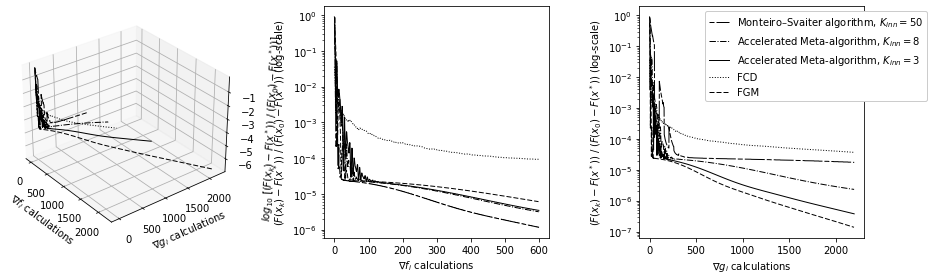

In [62]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(13,4))
fig.tight_layout()
ax = fig.add_subplot(131, projection='3d')

ax.plot(
    grad_h_count_ms_times[:length_grad_plot], 
    grad_g_count_ms_times[:length_grad_plot], 
    np.log10((funcs_ms_times[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),'k',
    label="Monteiro–Svaiter algorithm, $K_{inn} = 50$", dashes=[5, 2, 20, 2], linewidth=1
)

ax.plot(
    grad_h_count_taylor2_times[:length_grad_plot], 
    grad_g_count_taylor2_times[:length_grad_plot], 
    np.log10((funcs_taylor2_times[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),'k-.',
    label="Accelerated Meta-algorithm, $K_{inn} = 8$", linewidth=1
)

ax.plot(
    grad_h_count_taylor3_times[:length_grad_plot], 
    grad_g_count_taylor3_times[:length_grad_plot], 
    np.log10((funcs_taylor3_times[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),'k',
    label="Accelerated Meta-algorithm, $K_{inn} = 3$", linewidth=1
)

ax.plot(
    grad_h_count_times[:length_grad_plot], 
    grad_g_count_times[:length_grad_plot], 
    np.log10((funcs_times[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),'k:',
    label="FCD", linewidth=1
)

ax.plot(
    grad_h_count_fgm_times[:length_grad_plot], 
    grad_g_count_fgm_times[:length_grad_plot], 
    np.log10((funcs_fgm_times[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),'k',
    label="FGM", dashes=[5, 2], linewidth=1
)

# ax.legend()
ax.set_xlabel("$\\nabla f_i$ calculations")
ax.set_ylabel("$\\nabla g_i$ calculations")
ax.set_zlabel("$log_{10}\;[(F(x_k) - F(x^*))\;/\;(F(x_0) - F(x^*))]$")
ax.view_init(azim=-38)

ax1 = fig.add_subplot(132)
ax1.semilogy(
    grad_h_count_ms_times[:ms_grads_h_min_idx], 
    (funcs_ms_times[:ms_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt),'k',
    label="Monteiro–Svaiter algorithm, $K_{inn} = 50$", dashes=[5, 2, 20, 2], linewidth=1
)

ax1.semilogy(
    grad_h_count_taylor2_times[:taylor2_grads_h_min_idx], 
    (funcs_taylor2_times[:taylor2_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt),'k-.',
    label="Accelerated Meta-algorithm, $K_{inn} = 8$", linewidth=1
)

ax1.semilogy(
    grad_h_count_taylor3_times[:taylor3_grads_h_min_idx], 
    (funcs_taylor3_times[:taylor3_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt),'k',
    label="Accelerated Meta-algorithm, $K_{inn} = 3$", linewidth=1
)

ax1.semilogy(
    grad_h_count_times[:grads_h_min_idx], 
    (funcs_times[:grads_h_min_idx] - func_opt) / (f(x_0) - func_opt),'k:',
    label="FCD", linewidth=1
)

ax1.semilogy(
    grad_h_count_fgm_times[:fgm_grads_h_min_idx],
    (funcs_fgm_times[:fgm_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt),'k',
    label="FGM", dashes=[5, 2], linewidth=1
)

# ax1.legend(bbox_to_anchor=(1.2,1), loc="upper right")
ax1.set_xlabel("$\\nabla f_i$ calculations")
ax1.set_ylabel("$(F(x_k) - F(x^*))\;/\;(F(x_0) - F(x^*))$ (log-scale)")

ax2 = fig.add_subplot(133)
ax2.semilogy(
    grad_g_count_ms_times[:ms_grads_g_min_idx], 
    (funcs_ms_times[:ms_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt), 'k',
    label="Monteiro–Svaiter algorithm, $K_{inn} = 50$", dashes=[5, 2, 20, 2], linewidth=1
)

ax2.semilogy(
    grad_g_count_taylor2_times[:taylor2_grads_g_min_idx], 
    (funcs_taylor2_times[:taylor2_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt), 'k-.',
    label="Accelerated Meta-algorithm, $K_{inn} = 8$", linewidth=1
)

ax2.semilogy(
    grad_g_count_taylor3_times[:taylor3_grads_g_min_idx], 
    (funcs_taylor3_times[:taylor3_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt), 'k',
    label="Accelerated Meta-algorithm, $K_{inn} = 3$", linewidth=1
)

ax2.semilogy(
    grad_g_count_times[:grads_g_min_idx], 
    (funcs_times[:grads_g_min_idx] - func_opt) / (f(x_0) - func_opt), 'k:',
    label="FCD", linewidth=1
)

ax2.semilogy(
    grad_g_count_fgm_times[:fgm_grads_g_min_idx],
    (funcs_fgm_times[:fgm_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt), 'k',
    label="FGM", dashes=[5, 2], linewidth=1
)

# ax2.legend()
ax2.legend(bbox_to_anchor=(1.3,1), loc="upper right", framealpha=1)
ax2.set_xlabel("$\\nabla g_i$ calculations")
ax2.set_ylabel("$(F(x_k) - F(x^*))\;/\;(F(x_0) - F(x^*))$ (log-scale)")

plt.gcf().tight_layout()
plt.subplots_adjust(wspace = 0.4)

In [63]:
# Get working time limit for all methods
time_max = min(
    ms_times[-1] - ms_times[0],
    times[-1] - times[0],
    fgm_times[-1] - fgm_times[0],
    taylor2_times[-1] - taylor2_times[0],
    taylor3_times[-1] - taylor3_times[0]
)

In [64]:
# Get number of iteration, executing at the time `time_max`
ms_times_max_idx = np.searchsorted(np.array(ms_times) - ms_times[0], time_max, side="right")
times_max_idx = np.searchsorted(np.array(times) - times[0], time_max, side="right")
fgm_times_max_idx = np.searchsorted(np.array(fgm_times) - fgm_times[0], time_max, side="right")
taylor2_times_max_idx = np.searchsorted(np.array(taylor2_times) - taylor2_times[0], time_max, side="right")
taylor3_times_max_idx = np.searchsorted(np.array(taylor3_times) - taylor3_times[0], time_max, side="right")

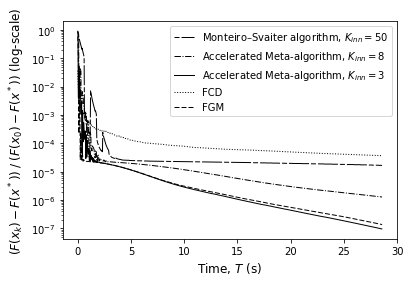

In [65]:
plt.semilogy((np.array(ms_times) - ms_times[0])[:ms_times_max_idx], (funcs_ms_times - func_opt)[:ms_times_max_idx] / (f(x_0) - func_opt), 
             'k', label="Monteiro–Svaiter algorithm, $K_{inn} = 50$", dashes=[5, 2, 20, 2], linewidth=1)
plt.semilogy((np.array(taylor2_times) - taylor2_times[0])[:taylor2_times_max_idx], (funcs_taylor2_times - func_opt)[:taylor2_times_max_idx] / (f(x_0) - func_opt), 
             'k-.', label="Accelerated Meta-algorithm, $K_{inn} = 8$", linewidth=1)
plt.semilogy((np.array(taylor3_times) - taylor3_times[0])[:taylor3_times_max_idx], (funcs_taylor3_times - func_opt)[:taylor3_times_max_idx] / (f(x_0) - func_opt), 
             'k', label="Accelerated Meta-algorithm, $K_{inn} = 3$", linewidth=1)
plt.semilogy((np.array(times) - times[0])[:times_max_idx], (funcs_times - func_opt)[:times_max_idx] / (f(x_0) - func_opt), 'k:', label="FCD", linewidth=1)
plt.semilogy((np.array(fgm_times) - fgm_times[0])[:fgm_times_max_idx], (funcs_fgm_times[:fgm_times_max_idx] - func_opt) / (f(x_0) - func_opt), 'k', label="FGM", dashes=[5, 2], linewidth=1)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"$(F(x_k) - F(x^*))\;/\;(F(x_0) - F(x^*))$ (log-scale)", fontsize=12)
plt.legend()

plt.show()

In [66]:
# Get number of iteration, executing at the time 0.5 s
time_min = 7.0

ms_times_min_idx = np.searchsorted(np.array(ms_times) - ms_times[0], time_min, side="right")
times_min_idx = np.searchsorted(np.array(times) - times[0], time_min, side="right")
fgm_times_min_idx = np.searchsorted(np.array(fgm_times) - fgm_times[0], time_min, side="right")
taylor2_times_min_idx = np.searchsorted(np.array(taylor2_times) - taylor2_times[0], time_min, side="right")
taylor3_times_min_idx = np.searchsorted(np.array(taylor3_times) - taylor3_times[0], time_min, side="right")

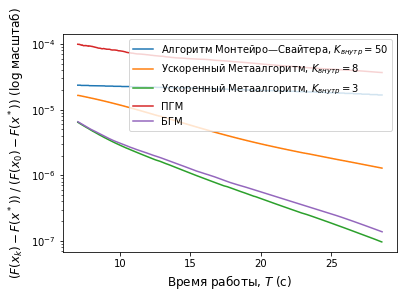

In [67]:
plt.semilogy((np.array(ms_times) - ms_times[0])[ms_times_min_idx:ms_times_max_idx], (funcs_ms_times - func_opt)[ms_times_min_idx:ms_times_max_idx] / (f(x_0) - func_opt), 
             label="Алгоритм Монтейро—Свайтера, $K_{внутр} = 50$")
plt.semilogy((np.array(taylor2_times) - taylor2_times[0])[taylor2_times_min_idx:taylor2_times_max_idx], (funcs_taylor2_times - func_opt)[taylor2_times_min_idx:taylor2_times_max_idx] / (f(x_0) - func_opt), 
             label="Ускоренный Метаалгоритм, $K_{внутр} = 8$")
plt.semilogy((np.array(taylor3_times) - taylor3_times[0])[taylor3_times_min_idx:taylor3_times_max_idx], (funcs_taylor3_times - func_opt)[taylor3_times_min_idx:taylor3_times_max_idx] / (f(x_0) - func_opt), 
             label="Ускоренный Метаалгоритм, $K_{внутр} = 3$")
plt.semilogy((np.array(times) - times[0])[times_min_idx:times_max_idx], (funcs_times - func_opt)[times_min_idx:times_max_idx] / (f(x_0) - func_opt), label="ПГМ")
plt.semilogy((np.array(fgm_times) - fgm_times[0])[fgm_times_min_idx:fgm_times_max_idx], (funcs_fgm_times[fgm_times_min_idx:fgm_times_max_idx] - func_opt) / (f(x_0) - func_opt), label="БГМ")


plt.xlabel(r"Время работы, $T$ (с)", fontsize=12)
plt.ylabel(r"$(F(x_k) - F(x^*))\;/\;(F(x_0) - F(x^*))$ (log масштаб)", fontsize=12)
plt.legend(loc='upper right')

plt.show()

In [68]:
# Get iterations limit for all methods
length = min(
    funcs_ms_times.shape[0],
    funcs_times.shape[0],
    funcs_fgm_times.shape[0],
    funcs_taylor2_times.shape[0],
    funcs_taylor3_times.shape[0]
)

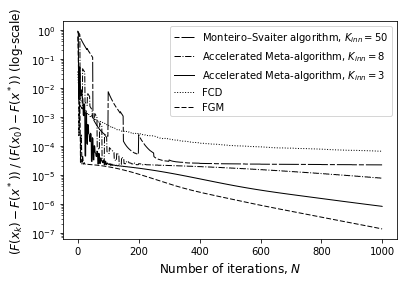

In [69]:
plt.semilogy((funcs_ms_times[:length] - func_opt) / (f(x_0) - func_opt), 'k', 
             label="Monteiro–Svaiter algorithm, $K_{inn} = 50$", dashes=[5, 2, 20, 2], linewidth=1)
plt.semilogy((funcs_taylor2_times[:length] - func_opt) / (f(x_0) - func_opt), 'k-.',
             label="Accelerated Meta-algorithm, $K_{inn} = 8$", linewidth=1)
plt.semilogy((funcs_taylor3_times[:length] - func_opt) / (f(x_0) - func_opt), 'k',
             label="Accelerated Meta-algorithm, $K_{inn} = 3$", linewidth=1)
plt.semilogy((funcs_times[:length] - func_opt) / (f(x_0) - func_opt), 'k:', label="FCD", linewidth=1)
plt.semilogy((funcs_fgm_times[:length] - func_opt) / (f(x_0) - func_opt), 'k', label="FGM", dashes=[5, 2], linewidth=1)

plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"$(F(x_k) - F(x^*))\;/\;(F(x_0) - F(x^*))$ (log-scale)", fontsize=12)
plt.legend()

plt.show()